# Dirichlet process Gaussian mixture model for halo splashback

Halos form within simulation as their constituent particles fall into ever-deepening potential wells. The measureable properties of the halos (Mass, concentration, splashback radius, etc.) evolves over time. This evolution is stochastic, since two halos with the same properties at one point in time will evolve differently as they interact with the environment differently. One halo may be in an over or under dense region of the Universe, or one may undergo a significant merger. Therefore, we are interested in capturing as much of the information about the halo population we have obtained as possible.

For this reason, we choose to model the joint distribution of halo properties $P(M,c,\nu,...)$. To represent this distribution, we will use a Gaussian mixture model (GMM), since one can analytically compute conditional probabilities from the joint distribution. Furthermore, since we have no a-priori knowledge of how many mixture components ($n$) are appropriate, we use a Dirichlet process (DP), which distribution over distributions used to sample different numbers of mixture components in a model such as ours.

## Gaussian mixture model

Suppose we have a halo with properties ${\bf x} = \{M,c,\nu,...\}$ (in practice all of the properties will be normalized to be unitless, e.g. $X_M = M_{\rm sp}/M_{\rm 200m}$). This halo, and all other halos, are assumed in our GMM to be generated from the following PDF:
$$
p({\bf x}_i|\{\pi_k,\mu_k,\Sigma_k\}_{k=1}^{n}) = \sum_{k=1}^n\pi_k \frac{1}{\sqrt{2\pi |\Sigma_k|}}
\exp\left(-\frac{1}{2}({\bf x}_i-\mu_k)^T\Sigma_k^{-1}({\bf x}_i-\mu_k) \right)\,.
$$
In this equation, there are $n$ individual multivariate Gaussian components with means given by $\mu_k$ and covariance matrices $\Sigma_k$. The probability that $x_i$ is drawn from an individual Gaussian is given by the weight $\pi_k$. In other words, $\pi_k$ is the proportion of halos that have been produced in a physical process that yield in the $k$-th distribution -- for example one mixture component could represent halos with major mergers while another halos that formed on the outskirts of voids. Since a detailed study of the evolution of individual halos is beyond the scope of this project, we make the simplifying assumption that different physical processes exist for different halos, and that the existence of these can be represented by the different components in our model.

In this model, individual halos are considered to have been drawn from individual components in the mixture model. Therefore, the probability of the 'label' $z_i\in\{1,2,...,n\}$ for halo $i$ is given by 
$$
p(z_i|\{\pi_k\}_{k=1}^{n}) = \pi_k \delta(z_i,k) = \prod_{k=1}^{n} \pi_k^{\delta(z_i,k)}\,.
$$
Building on this, we can now construct the joint probability of the halo properties for all $N$ halos ${\bf X} = \{{\bf x}_i\}_{i=1}^{N}$ and their component labels ${\bf z} = \{z_i\}_{i=1}^{N}$. To save space, I will write $\Omega = \{\pi_k,\mu_k,\Sigma_k\}_{k=1}^{n}$. The joint distribution is given by
$$
p({\bf X}, {\bf z}|\Omega) = p({\bf z}|\{\pi_k\}_{k=1}^{n}) p({\bf X} | {\bf z}, \Omega)\\
 = p({\bf X} | {\bf z}, \Omega) \prod_{i=1}^N \prod_{k=1}^{n} \pi_k^{\delta(z_i,k)}\\
  = \prod_{i=1}^N \prod_{k=1}^{n} \left( \pi_k \frac{1}{\sqrt{2\pi |\Sigma_k|}}
\exp\left(-\frac{1}{2}({\bf x}_i-\mu_k)^T\Sigma_k^{-1}({\bf x}_i-\mu_k) \right)\right)^{\delta(z_i,k)}
$$
We can see by eye that taking the log yields a sum over terms of the probabilities of halo properties of their assigned components, meaning we only actually deal with $N$ different terms in the sum, rather than $N\times n$.

In our case, our observations are ${\bf X}$, without any components labels ${\bf z}$. Therefore, we are interested in maximizing the posterior on the parameters in our model
$$
p({\bf z},\Omega|{\bf X}) = p({\bf X}|{\bf z},\Omega) p({\bf z},\Omega)\\
 = p({\bf X}|{\bf z},\{\pi_k,\mu_k,\Sigma_k\}_{k=1}^{n}) p({\bf z}|\{\pi_k\}_{k=1}^{n}) p(\{\pi_k,\mu_k,\Sigma_k\}_{k=1}^{n})\,.
$$
In the second line, the first term is the probability of the observations in our GMM, the middle term is the probability of the labels given the weights, and the last term is the prior on the weights, means, and covariance matrices in our GMM.

Note that, later, when we aren't interested in the labels anymore, we can still evaluate $p({\bf X}|\Omega)$ as being
$$
p({\bf X}|\Omega) = \prod_{i=1}^N \prod_{k=1}^{n} \pi_k \frac{1}{\sqrt{2\pi |\Sigma_k|}}
\exp\left(-\frac{1}{2}({\bf x}_i-\mu_k)^T\Sigma_k^{-1}({\bf x}_i-\mu_k) \right)\,,
$$
that is, it is identical to $p({\bf X}, {\bf z}|\Omega)$, but now the delta function $\delta(z_i,k)$ in the exponent is gone, since a given $x_i$ can have originated from any component. In taking the log probability, we see that will will have $N\times n$ terms.

## Enter stage right: the Dirichlet process

You will have noticed that at no point have I specified how many components $n$ there actually are. At first glance, this makes the problem seem very difficult, since if we have no a-priori knowledge of what $n$ should be then in principle the number of parameters is unbound. This is actually OK, since this kind of hurlde is handled by recasting the problem (via the prior $p(\{\pi_k,\mu_k,\Sigma_k\}_{k=1}^{n})$) as a _Dirichlet process_ (DP).

A detailed description of this algorithm is beyond the scope of this work, but the essentials are as follows. The DP is, in fact, a prior over the possible distributions that include various numbers of components in our GMM. In practice, one can think of the DP as a way of probabilistically adding an additional component to the GMM if it is deemed necessary (i.e. if a random draw performed in the algorithm is above some probability threshold).

INSERT EQUATIONS HERE

## Caveats: correlated halos

The main downside of this prescription is that it neglects the fact that halos evolved in a correlated matter. For instance, two halos in the vicinity of one another will influence each other gravitationally, meaning there is correlated structure in our sample that we are not modeling. For now, we neglect this since it is a perturbation on top of the GMM we are constraining.

In [1]:
import itertools
import numpy as np
from scipy import linalg
from sklearn import mixture
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [2]:
#Read in the halo catalog
from catalog import *
#Select a simulation
length       = 2000 #Mpc/h comoving
scale_factor = 1.
#Create the Catalog object
cat = Catalog([length], scale_factor)
print(len(cat.property("Spin")))
cat.add_property("lnSpin", np.log(cat.property("Spin")))

7950


In [3]:
#Format for the plots
plt.rc("text", usetex=True)
plt.rc("font", size=18, family="serif")

In [4]:
#Colors to iterate over -- we will have a max of 5 components for now
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

In [5]:
#Define a function to plot the Gaussian 1sigma ellipses generated by a mixture model
def plot_results(X, Y_, means, covariances, index, labels, title=None):
    """
    Note: X must be [N_points x 2].
    
    Args:
        X (array): 2D array with points and the two dimensions we are plotting them in
        Y (array): 1D array of the labels of the points
        means (array): 1D array of means of the underlying Gaussians
        covariance (array): list of 2D arrays (i.e. a 3D array) that represent the covariance matrices of the Gaussians
        index (int): which subplot we are plotting on
        title (string): title for the subplot
        labels (list): axis labels
        
    Returns:
        None
    """
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            print("Skipped component %d"%i)
            continue
        print("N in %d = %d"%(i, len(X[Y_==i])))
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(-9., 5.)
    #plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    if title is not None:
        plt.title(title)
    return

In [6]:
#Create an array with the properties we are looking at for now
X = np.array([cat.property("X_Rsp_mean"), cat.property("Acc_Rate_2*Tdyn")/np.max(cat.property("Acc_Rate_2*Tdyn"))]).T#, cat.property("nusp_mean")]).T
labels = [r"$X_{R,{\rm mean}}$", r"$2T_{\rm dyn}\Gamma$"]#, r"$\nu_{\rm mean}$"]
print(X[:10])

[[0.73968964 0.32769407]
 [1.10050756 0.09203606]
 [0.64475953 0.34708409]
 [0.77017536 0.38132149]
 [1.0364982  0.15501869]
 [0.65462717 0.27526875]
 [0.56370034 0.56595704]
 [0.82857426 0.19783067]
 [0.6131491  0.40053354]
 [0.72449838 0.30075866]]


In [7]:
# Fit a Dirichlet process Gaussian mixture using five components max
n_components = 6
dpgmm = mixture.BayesianGaussianMixture(n_components=n_components,
                                        covariance_type='full', 
                                        tol=1e-4,#).fit(X)
                                        weight_concentration_prior=1e-9).fit(X)
#                                        weight_concentration_prior=1./n_components).fit(X)

//anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


N in 0 = 2755
N in 1 = 1439
N in 2 = 1065
N in 3 = 37
N in 4 = 2559
N in 5 = 95


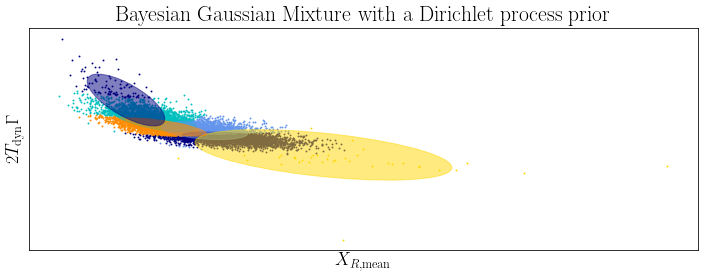

In [8]:
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 0, 
             labels, 'Bayesian Gaussian Mixture with a Dirichlet process prior')
fig = plt.gcf()
fig.set_size_inches(12, 9)

In [9]:
print(dpgmm.weights_)

[0.28171391 0.23092638 0.20790208 0.00611968 0.25044228 0.02289566]
